# individual report of England during the EURO

### Prepare the Data

In [28]:
# Import the required libraries
from statsbombpy import sb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mplsoccer import Pitch
from matplotlib.colors import to_rgba
import seaborn as sns
from sklearn import preprocessing

# Get all competitions
competitionsDB = pd.DataFrame(sb.competitions())
# Filter only the 2022 women's euro, id is 53
women_euro = competitionsDB[competitionsDB['competition_id'] == 53]

# Get the England's matches, 53 is competition_id and 106 is season_id
games = sb.matches(53, 106)

We have the references of all the Euro's games, let's compute the radar charts of strikers and Lucy Bronze

In [52]:
# Let's get all the ids of the games
games_ids = [game[1]['match_id'] for game in games.iterrows()]

# Initialize the DF
players_df = pd.DataFrame(columns=['player', 'Goals/90', 'xG/90', 'xG/Shot', 'Shots/90', 'Dribbles/90', 'TouchesinBox/90',
                                     'Pressures/90', 'Assists/90', 'Passes/90', 'Key Passes/90'])

players_names = ['Bethany Mead', 'Alexandra Popp', 'Romée Leuchter', 'Kosovare Asllani', 'Melvine Malard']

for id in games_ids:

    # For each game, get the home_team and the away team
    home_team = str(games[games.match_id == id]['home_team'].values[0])
    away_team = str(games[games.match_id == id]['away_team'].values[0])

    # Get the events of the game and filter for the players
    events = sb.events(id)
    player_events = events[events.player.isin(players_names)]
    player_events_h = player_events[player_events.team == home_team]
    player_events_a = player_events[player_events.team == away_team]
    # Get players names
    if len(player_events_h)>0:
        player_h = player_events_h.head(1).player.values[0]
    if len(player_events_a)>0:
        player_a = player_events_a.head(1).player.values[0]
    # Get the number of minutes of the game
    minute_played = max(events['minute'])

    # Get the passes relatives metrics
    # Get the passes
    passes_player_h = player_events_h[player_events_h.type == 'Pass']
    passes_player_a = player_events_a[player_events_a.type == 'Pass']

    # Get the assists
    if 'pass_goal_assist' in passes_player_h.keys():
        # print(passes_player['pass_goal_assist'])
        assists_player_h = passes_player_h[passes_player_h['pass_goal_assist'] == True]
        assists_player_a = passes_player_a[passes_player_a['pass_goal_assist'] == True]

    # Get the key passes
    key_player_h = passes_player_h[passes_player_h['pass_shot_assist'] == True]
    key_player_a = passes_player_a[passes_player_a['pass_shot_assist'] == True]

    # Get per 90
    assists_h_90 = len(assists_player_h) * 90 / minute_played
    assists_a_90 = len(assists_player_a) * 90 / minute_played

    key_h_90 = (len(key_player_h)+len(assists_player_h)) * 90 / minute_played
    key_a_90 = (len(key_player_a)+len(assists_player_a)) * 90 / minute_played

    passes_h_90 = len(passes_player_h) * 90 / minute_played
    passes_a_90 = len(passes_player_a) * 90 / minute_played

    # Get the shots
    shots_player_h = player_events_h[player_events_h.type == 'Shot']
    shots_player_a = player_events_a[player_events_a.type == 'Shot']

    # Get the goals
    goal_player_h = shots_player_h[shots_player_h['shot_outcome'] == "Goal"]
    goal_player_a = shots_player_a[shots_player_a['shot_outcome'] == "Goal"]

    # Get per 90
    xg_sum_home = shots_player_h['shot_statsbomb_xg'].sum()
    xg_sum_away = shots_player_a['shot_statsbomb_xg'].sum()
    xg_per_90_h = xg_sum_home * 90 / minute_played
    xg_per_90_a = xg_sum_away * 90 / minute_played

    goal_h_90 = len(goal_player_h) * 90 / minute_played
    goal_a_90 = len(goal_player_a) * 90 / minute_played

    shots_h_90 = len(shots_player_h) * 90 / minute_played
    shots_a_90 = len(shots_player_a) * 90 / minute_played

    xg_shot_h = xg_sum_home / len(shots_player_h)
    xg_shot_a = xg_sum_away / len(shots_player_a)


    # Get the pressure
    pressures_player_h = player_events_h[player_events_h.type == 'Pressure']
    pressures_player_a = player_events_a[player_events_a.type == 'Pressure']

    # Get per 90
    pressures_h_90 = len(pressures_player_h) * 90 / minute_played
    pressures_a_90 = len(pressures_player_a) * 90 / minute_played

    # Get the dribbles
    dribbles_player_h = player_events_h[player_events_h.type == 'Dribble']
    dribbles_player_a = player_events_a[player_events_a.type == 'Dribble']

    dribbles_h_90 = len(dribbles_player_h) * 90 / minute_played
    dribbles_a_90 = len(dribbles_player_a) * 90 / minute_played

    # Get the receipt
    receipt_player_h = player_events_h[player_events_h.type == 'Ball Receipt*']
    receipt_player_a = player_events_a[player_events_a.type == 'Ball Receipt*']

    # Get the ones in the box
    inbox_player_h = receipt_player_h[receipt_player_h.location.apply(lambda x: x[0]) > 95]
    inbox_player_h = inbox_player_h[inbox_player_h.location.apply(lambda x: x[1]) > 16]
    inbox_player_h = inbox_player_h[inbox_player_h.location.apply(lambda x: x[1]) < 64]
    inbox_player_a = receipt_player_a[receipt_player_a.location.apply(lambda x: x[0]) > 95]
    inbox_player_a = inbox_player_a[inbox_player_a.location.apply(lambda x: x[1]) > 16]
    inbox_player_a = inbox_player_a[inbox_player_a.location.apply(lambda x: x[1]) < 64]

    # Get per 90
    inbox_h_90 = len(inbox_player_h) * 90 / minute_played
    inbox_a_90 = len(inbox_player_a) * 90 / minute_played


    # Add to Dataframe
    home_series = pd.Series({'player': player_h, 'Passes/90' : passes_h_90, 'Key Passes/90' : key_h_90, 'assists/90' : assists_h_90,
                             'Goals/90': goal_h_90, 'xG/90' : xg_per_90_h, 'xG/Shot' :xg_shot_h, 'Shots/90':shots_h_90,
                             'Dribbles/90': dribbles_h_90, 'TouchesinBox/90':inbox_h_90, 'Pressures/90' : pressures_h_90})
    away_series = pd.Series({'player': player_a, 'Passes/90' : passes_a_90, 'Key Passes/90' : key_a_90, 'assists/90' : assists_a_90,
                             'Goals/90': goal_a_90, 'xG/90' : xg_per_90_a, 'xG/Shot' :xg_shot_a, 'Shots/90':shots_a_90,
                             'Dribbles/90': dribbles_a_90, 'TouchesinBox/90':inbox_a_90, 'Pressures/90' : pressures_a_90})
    if len(player_events_h) > 0:
        players_df = players_df.append(home_series, ignore_index=True)
    if len(player_events_a) > 0:
        players_df = players_df.append(away_series, ignore_index = True)

print(players_df)


C:\Users\axelg\AppData\Local\Temp\ipykernel_21672\3962491371.py:74: RuntimeWarning: invalid value encountered in double_scalars
  xg_shot_h = xg_sum_home / len(shots_player_h)
C:\Users\axelg\AppData\Local\Temp\ipykernel_21672\3962491371.py:75: RuntimeWarning: invalid value encountered in double_scalars
  xg_shot_a = xg_sum_away / len(shots_player_a)
C:\Users\axelg\AppData\Local\Temp\ipykernel_21672\3962491371.py:118: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  players_df = players_df.append(home_series, ignore_index=True)
C:\Users\axelg\AppData\Local\Temp\ipykernel_21672\3962491371.py:75: RuntimeWarning: invalid value encountered in double_scalars
  xg_shot_a = xg_sum_away / len(shots_player_a)
C:\Users\axelg\AppData\Local\Temp\ipykernel_21672\3962491371.py:118: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  p

              player  Goals/90     xG/90   xG/Shot  Shots/90  Dribbles/90  \
0       Bethany Mead  0.000000  0.000000       NaN  0.000000     0.737705   
1       Bethany Mead  0.967742  0.292167  0.075476  3.870968     0.000000   
2   Kosovare Asllani  0.000000  0.000000       NaN  0.000000     2.903226   
3       Bethany Mead  1.000000  0.758231  0.151646  5.000000     4.000000   
4     Melvine Malard  0.000000  0.000000       NaN  0.000000     2.812500   
5   Kosovare Asllani  0.000000  0.243024  0.084608  2.872340     4.787234   
6   Kosovare Asllani  0.000000  0.276600  0.098347  2.812500     4.687500   
7     Alexandra Popp  1.894737  0.306998  0.108018  2.842105     0.000000   
8     Melvine Malard  0.000000  0.000000       NaN  0.000000     0.947368   
9     Melvine Malard  0.000000  0.527050  0.357223  1.475410     0.000000   
10    Romée Leuchter  0.000000  0.000000       NaN  0.000000     0.000000   
11      Bethany Mead  0.000000  0.000000       NaN  0.000000     2.903226   

In [60]:
players_df = players_df.groupby(['player']).mean()

print(players_df.values.tolist()[0])

[1.1511266528351256, 0.4955253597392756, 0.14710132994333333, 3.076403506154303, 0.574468085106383, 6.92485201245781, 14.042253525550919, 17.27877005036838, 0.9657276715108472, 0.0]


['Alexandra Popp', 'Bethany Mead', 'Kosovare Asllani', 'Melvine Malard', 'Romée Leuchter']


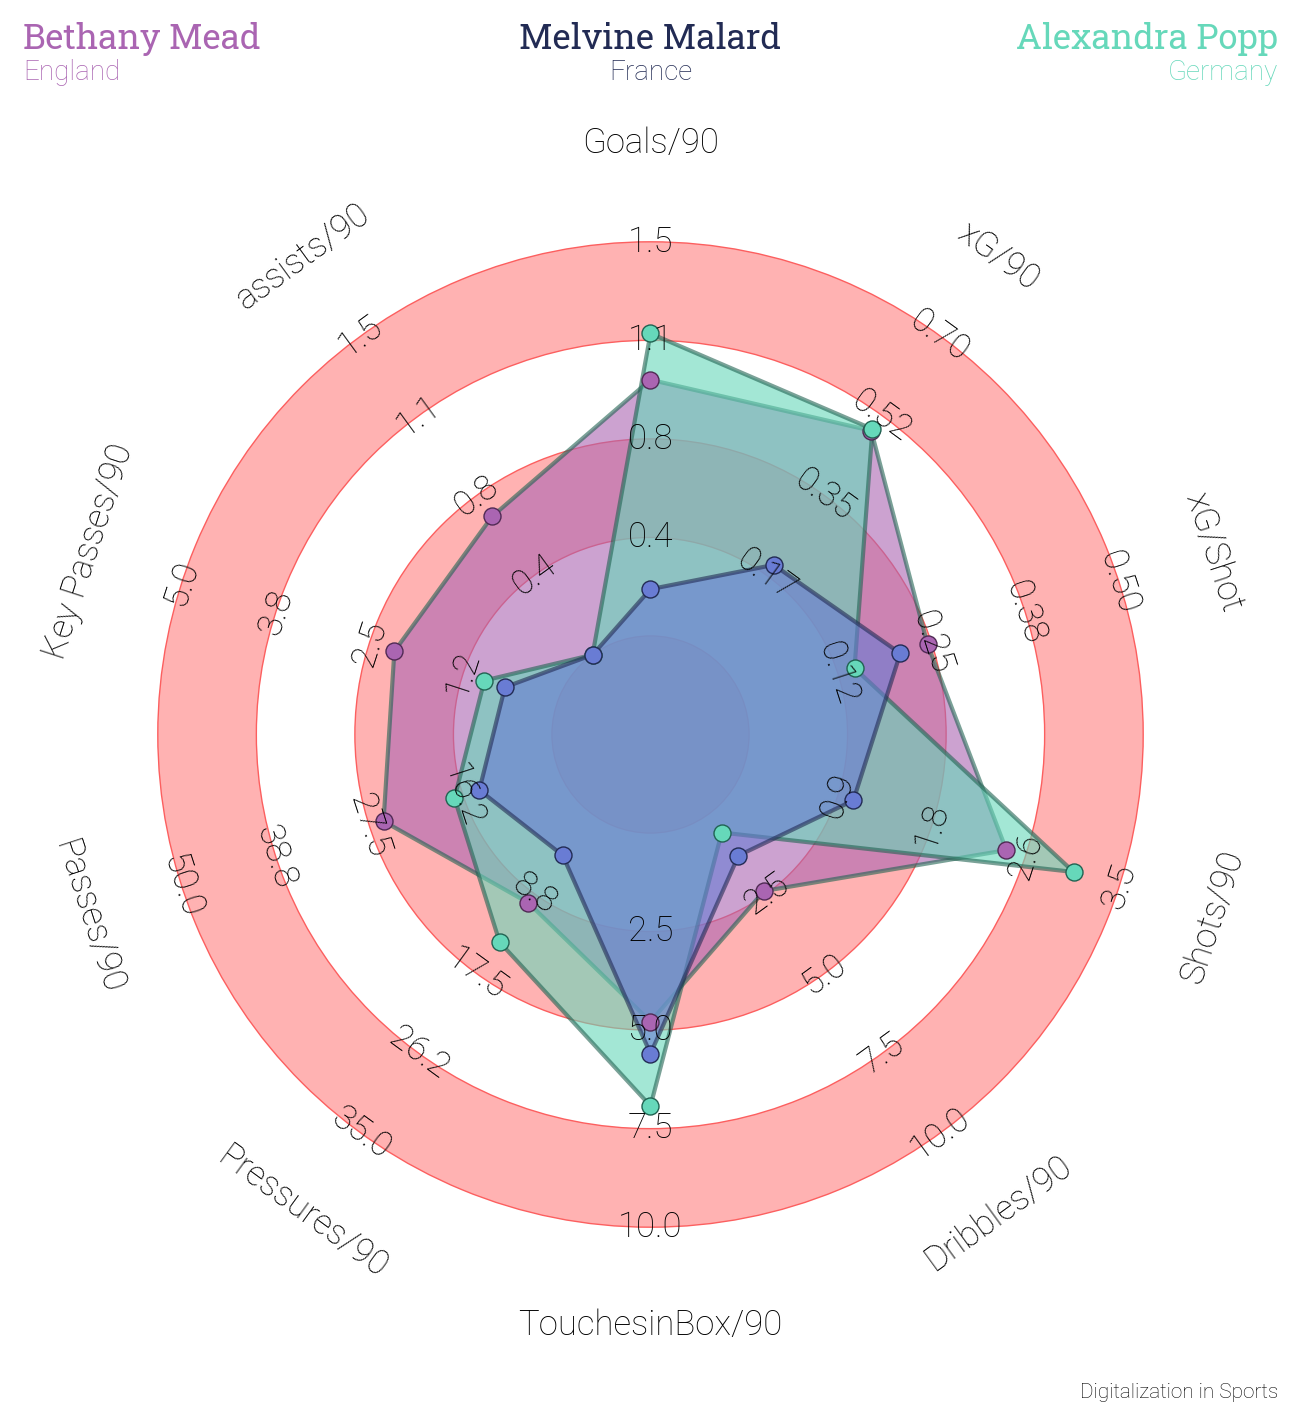

In [112]:
# Source : https://mplsoccer.readthedocs.io/en/latest/gallery/radar/plot_radar.html

from mplsoccer import Radar, FontManager, grid
import matplotlib.pyplot as plt

URL4 = 'https://raw.githubusercontent.com/googlefonts/roboto/main/src/hinted/Roboto-Thin.ttf'
robotto_thin = FontManager(URL4)

URL5 = ('https://raw.githubusercontent.com/google/fonts/main/apache/robotoslab/'
        'RobotoSlab%5Bwght%5D.ttf')
robotto_bold = FontManager(URL5)

# parameter names of the statistics we want to show
params = players_df.columns

players = players_df.index.tolist()
print(players)

popp_values = players_df.values.tolist()[0]
mead_values = players_df.values.tolist()[1]
asllani_values = players_df.values.tolist()[2]
mallard_values = players_df.values.tolist()[3]
leuchter_values = players_df.values.tolist()[4]

# The lower and upper boundaries for the statistics
low =  [0.00, 0.0, 0.0, 0.0, 0.0,  0, 0, 5.0, 0.0, 0.0]
high = [1.5, 0.7, 0.5, 3.5, 10, 10, 35, 50, 5.0, 1.5]

# Add anything to this list where having a lower number is better
# this flips the statistic
lower_is_better = ['Miscontrol']

radar = Radar(params, low, high,
              lower_is_better=lower_is_better,
              # whether to round any of the labels to integers instead of decimal places
              round_int=[False]*len(params),
              num_rings=4,  # the number of concentric circles (excluding center circle)
              # if the ring_width is more than the center_circle_radius then
              # the center circle radius will be wider than the width of the concentric circles
              ring_width=1, center_circle_radius=1)

# creating the figure using the grid function from mplsoccer:
fig, axs = grid(figheight=14, grid_height=0.915, title_height=0.06, endnote_height=0.025,
                title_space=0, endnote_space=0, grid_key='radar', axis=False)

# plot radar
radar.setup_axis(ax=axs['radar'])  # format axis as a radar

rings_inner = radar.draw_circles(ax=axs['radar'], facecolor='#ffb2b2', edgecolor='#fc5f5f')

radar1, vertices1 = radar.draw_radar_solid(mead_values, ax=axs['radar'],
                                           kwargs={'facecolor': '#aa65b2',
                                                   'alpha': 0.6,
                                                   'edgecolor': '#216352',
                                                   'lw': 3})

radar2, vertices2 = radar.draw_radar_solid(popp_values, ax=axs['radar'],
                                           kwargs={'facecolor': '#66d8ba',
                                                   'alpha': 0.6,
                                                   'edgecolor': '#216352',
                                                   'lw': 3})

radar3, vertices3 = radar.draw_radar_solid(mallard_values, ax=axs['radar'],
                                           kwargs={'facecolor': '#697cd4',
                                                   'alpha': 0.6,
                                                   'edgecolor': '#222b54',
                                                   'lw': 3})


axs['radar'].scatter(vertices1[:, 0], vertices1[:, 1],
           c='#aa65b2', edgecolors='#502a54', marker='o', s=150, zorder=2)
axs['radar'].scatter(vertices2[:, 0], vertices2[:, 1],
           c='#66d8ba', edgecolors='#216352', marker='o', s=150, zorder=2)
axs['radar'].scatter(vertices3[:, 0], vertices3[:, 1],
           c='#697cd4', edgecolors='#222b54', marker='o', s=150, zorder=2)

range_labels = radar.draw_range_labels(ax=axs['radar'], fontsize=25, fontproperties=robotto_thin.prop)
param_labels = radar.draw_param_labels(ax=axs['radar'], fontsize=25, fontproperties=robotto_thin.prop)


# adding the endnote and title text (these axes range from 0-1, i.e. 0, 0 is the bottom left)
# Note we are slightly offsetting the text from the edges by 0.01 (1%, e.g. 0.99)
endnote_text = axs['endnote'].text(0.99, 0.5, 'Digitalization in Sports', fontsize=15,
                                   fontproperties=robotto_thin.prop, ha='right', va='center')
title1_text = axs['title'].text(0.01, 0.65, 'Bethany Mead', fontsize=25, color='#aa65b2',
                                fontproperties=robotto_bold.prop, ha='left', va='center')
title2_text = axs['title'].text(0.01, 0.25, 'England', fontsize=20,
                                fontproperties=robotto_thin.prop,
                                ha='left', va='center', color='#aa65b2')
title3_text = axs['title'].text(0.99, 0.65, 'Alexandra Popp', fontsize=25,
                                fontproperties=robotto_bold.prop,
                                ha='right', va='center', color='#66d8ba')
title4_text = axs['title'].text(0.99, 0.25, 'Germany', fontsize=20,
                                fontproperties=robotto_thin.prop,
                                ha='right', va='center', color='#66d8ba')
title5_text = axs['title'].text(0.5, 0.65, 'Melvine Malard', fontsize=25,
                                fontproperties=robotto_bold.prop,
                                ha='center', va='center', color='#222b54')
title6_text = axs['title'].text(0.5, 0.25, 'France', fontsize=20,
                                fontproperties=robotto_thin.prop,
                                ha='center', va='center', color='#222b54')

plt.savefig('visualizations/Players/Strikers_comparison_1.png', dpi=300, bbox_inches='tight')
plt.show()


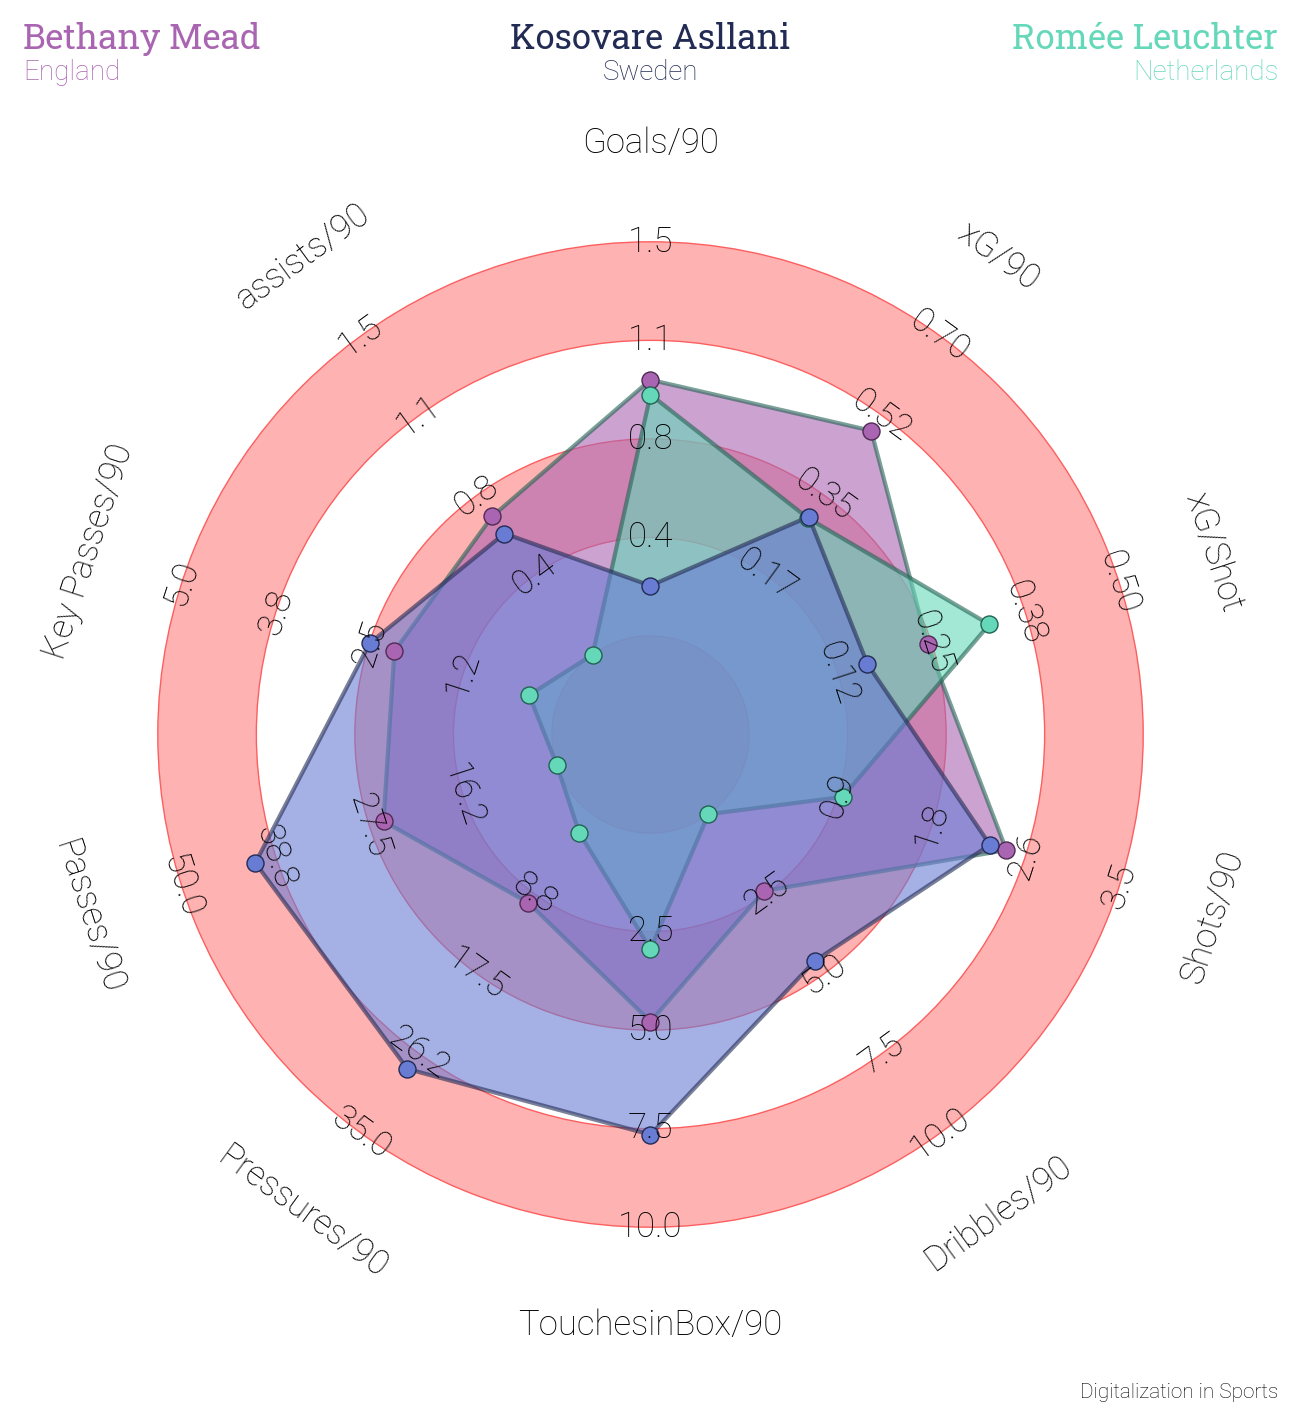

In [111]:
# Add anything to this list where having a lower number is better
# this flips the statistic
lower_is_better = ['Miscontrol']

radar = Radar(params, low, high,
              lower_is_better=lower_is_better,
              # whether to round any of the labels to integers instead of decimal places
              round_int=[False]*len(params),
              num_rings=4,  # the number of concentric circles (excluding center circle)
              # if the ring_width is more than the center_circle_radius then
              # the center circle radius will be wider than the width of the concentric circles
              ring_width=1, center_circle_radius=1)

# creating the figure using the grid function from mplsoccer:
fig, axs = grid(figheight=14, grid_height=0.915, title_height=0.06, endnote_height=0.025,
                title_space=0, endnote_space=0, grid_key='radar', axis=False)

# plot radar
radar.setup_axis(ax=axs['radar'])  # format axis as a radar

rings_inner = radar.draw_circles(ax=axs['radar'], facecolor='#ffb2b2', edgecolor='#fc5f5f')

radar1, vertices1 = radar.draw_radar_solid(mead_values, ax=axs['radar'],
                                           kwargs={'facecolor': '#aa65b2',
                                                   'alpha': 0.6,
                                                   'edgecolor': '#216352',
                                                   'lw': 3})

radar2, vertices2 = radar.draw_radar_solid(leuchter_values, ax=axs['radar'],
                                           kwargs={'facecolor': '#66d8ba',
                                                   'alpha': 0.6,
                                                   'edgecolor': '#216352',
                                                   'lw': 3})

radar3, vertices3 = radar.draw_radar_solid(asllani_values, ax=axs['radar'],
                                           kwargs={'facecolor': '#697cd4',
                                                   'alpha': 0.6,
                                                   'edgecolor': '#222b54',
                                                   'lw': 3})


axs['radar'].scatter(vertices1[:, 0], vertices1[:, 1],
           c='#aa65b2', edgecolors='#502a54', marker='o', s=150, zorder=2)
axs['radar'].scatter(vertices2[:, 0], vertices2[:, 1],
           c='#66d8ba', edgecolors='#216352', marker='o', s=150, zorder=2)
axs['radar'].scatter(vertices3[:, 0], vertices3[:, 1],
           c='#697cd4', edgecolors='#222b54', marker='o', s=150, zorder=2)

range_labels = radar.draw_range_labels(ax=axs['radar'], fontsize=25, fontproperties=robotto_thin.prop)
param_labels = radar.draw_param_labels(ax=axs['radar'], fontsize=25, fontproperties=robotto_thin.prop)


# adding the endnote and title text (these axes range from 0-1, i.e. 0, 0 is the bottom left)
# Note we are slightly offsetting the text from the edges by 0.01 (1%, e.g. 0.99)
endnote_text = axs['endnote'].text(0.99, 0.5, 'Digitalization in Sports', fontsize=15,
                                   fontproperties=robotto_thin.prop, ha='right', va='center')
title1_text = axs['title'].text(0.01, 0.65, 'Bethany Mead', fontsize=25, color='#aa65b2',
                                fontproperties=robotto_bold.prop, ha='left', va='center')
title2_text = axs['title'].text(0.01, 0.25, 'England', fontsize=20,
                                fontproperties=robotto_thin.prop,
                                ha='left', va='center', color='#aa65b2')
title3_text = axs['title'].text(0.99, 0.65, 'Romée Leuchter', fontsize=25,
                                fontproperties=robotto_bold.prop,
                                ha='right', va='center', color='#66d8ba')
title4_text = axs['title'].text(0.99, 0.25, 'Netherlands', fontsize=20,
                                fontproperties=robotto_thin.prop,
                                ha='right', va='center', color='#66d8ba')
title5_text = axs['title'].text(0.5, 0.65, 'Kosovare Asllani', fontsize=25,
                                fontproperties=robotto_bold.prop,
                                ha='center', va='center', color='#222b54')
title6_text = axs['title'].text(0.5, 0.25, 'Sweden', fontsize=20,
                                fontproperties=robotto_thin.prop,
                                ha='center', va='center', color='#222b54')

plt.savefig('visualizations/Players/Strikers_comparison_2.png', dpi=300, bbox_inches='tight')
plt.show()